<a href="https://colab.research.google.com/github/pankhuri25/Flipkart-Ecommerce-Product-Categorization/blob/main/Product%20Classification%20using%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Product Category Prediction for Flipkart Dataset using RNN-LSTM Model**

# ***Objective:***

1. Data Preparation: Cleaning and Analysing data
2. Visualize this Data
3. Preprocessing textual Data 
4. Model Preparation for product categorization
5. Measure the accuracy of the model
6. Can we improve the accuracy of the model?
7. What other algorithms can we try?



## ***Third Party Imports***

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import gensim

from keras.preprocessing.text import Tokenizer

from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk import WordPunctTokenizer
from sklearn.model_selection import train_test_split

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## ***1. Data Preparation: Cleaning and Analysing data***

## Load Flipkart E-Commerce Dataset

In [8]:
df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/flipkart_com-ecommerce_sample - flipkart_com-ecommerce_sample - flipkart_com-ecommerce_sample.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  20000 non-null  object 
 1   crawl_timestamp          20000 non-null  object 
 2   product_url              20000 non-null  object 
 3   product_name             20000 non-null  object 
 4   product_category_tree    20000 non-null  object 
 5   pid                      20000 non-null  object 
 6   retail_price             19922 non-null  float64
 7   discounted_price         19922 non-null  float64
 8   image                    19997 non-null  object 
 9   is_FK_Advantage_product  20000 non-null  bool   
 10  description              19998 non-null  object 
 11  product_rating           20000 non-null  object 
 12  overall_rating           20000 non-null  object 
 13  brand                    14136 non-null  object 
 14  product_specifications

## View the data and analyze rows and columns

In [9]:
df.head(n=5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."


## Get the Primary Categories

In [10]:
import re

#################################################################################################

# Extract the main category from product_category_tree column by specifying regex pattern. 
# If not found, split the sentence and get the first token after removing extra spaces and chars.

#################################################################################################

categories = df["product_category_tree"].copy()

for i in range(categories.shape[0]):
  z = re.match("(.*?)>",categories[i])  # splitting at '>'
  # print(categories[i])
  if z==None:
    categories[i] = categories[i].split()[0].strip('["]')
  else:
    z = z.group().strip('["]>')         # removing special characters
    categories[i]=z.strip()

print(categories)


0            Clothing
1           Furniture
2            Footwear
3            Clothing
4        Pet Supplies
             ...     
19995       Baby Care
19996       Baby Care
19997       Baby Care
19998       Baby Care
19999       Baby Care
Name: product_category_tree, Length: 20000, dtype: object


In [11]:
# Let's see top 40 unique categories with their frequencies

print(categories.value_counts()[:40])

Clothing                             6198
Jewellery                            3531
Footwear                             1227
Mobiles & Accessories                1099
Automotive                           1012
Home Decor & Festive Needs            929
Beauty and Personal Care              710
Home Furnishing                       700
Kitchen & Dining                      647
Computers                             578
Watches                               530
Baby Care                             483
Tools & Hardware                      391
Toys & School Supplies                330
Pens & Stationery                     313
Bags, Wallets & Belts                 265
Furniture                             180
Sports & Fitness                      166
Cameras & Accessories                  82
Home Improvement                       81
Health & Personal Care Appliances      43
Sunglasses                             40
Gaming                                 35
Pet Supplies                      

# ---------------------------------------------------------------------------------------------------------------------------------------------

As we can observe, there are some categories with frequency of 4 samples or above: 
*   Clovia  (clothing)
*   Olvin   (sunglasses)
*   Vishudh (clothing)
*   Dressberry (clothing)
*   Lilliput (baby care)
*   Speedwav (automotive)
*   MASARA (clothing)
*   Ruhi's (clothing)
*   Timberlake (clothing)
*   FEET (footwear)
*   Urban (beauty and personal care)

These are not valid primary categories (instead, they are Brand names) and actually belong to Clothing, Sunglasses, Baby Care, Automotive , Footwear and other categories *(conclusion on the basis of careful inspection of data)*.

So, we should replace these labels with major primary category.

This will be our next step.

*Note: We are not focusing on the left out labels (brand names) with frequency below 4 for now.*

# ---------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
for i in range(categories.shape[0]):
  if (categories[i]=="Clovia" 
      or categories[i]=="Vishudh" 
      or categories[i]=="Dressberry" 
      or categories[i]=="MASARA" 
      or categories[i]=="Ruhi's" 
      or categories[i]=="TIMBERLAKE"):
    categories[i] = "Clothing"
  elif categories[i]=="Olvin":
    categories[i] = "Sunglasses"
  elif categories[i]=="Lilliput":
    categories[i] = "Baby Care"
  elif categories[i]=="Speedwav":
    categories[i] = "Automotive"
  elif categories[i]=="FEET":
    categories[i] = "Footwear"
  elif categories[i]=="Urban":
    categories[i] = "Beauty and Personal Care"

print("TOP 30 Valid Product Categories:\n\n",categories.value_counts()[:30])

TOP 30 Valid Product Categories:

 Clothing                             6247
Jewellery                            3531
Footwear                             1231
Mobiles & Accessories                1099
Automotive                           1019
Home Decor & Festive Needs            929
Beauty and Personal Care              714
Home Furnishing                       700
Kitchen & Dining                      647
Computers                             578
Watches                               530
Baby Care                             491
Tools & Hardware                      391
Toys & School Supplies                330
Pens & Stationery                     313
Bags, Wallets & Belts                 265
Furniture                             180
Sports & Fitness                      166
Cameras & Accessories                  82
Home Improvement                       81
Sunglasses                             56
Health & Personal Care Appliances      43
Gaming                                 35

## View possible Primary Categories

In [17]:
############################################################
# Let's have a look at all the unique category names 
# We will talk about their significance and validty later
############################################################

possible_labels = categories.unique()

print(type(possible_labels))
print("\n")
print("Possible Labels: \n", possible_labels)
print("\n")
print("Number of possible categories:", len(possible_labels))

<class 'numpy.ndarray'>


Possible Labels: 
 ['Clothing' 'Furniture' 'Footwear' 'Pet Supplies' 'Eternal'
 'Pens & Stationery' 'Sports & Fitness' 'Beauty and Personal Care'
 'Bengal' 'Bags, Wallets & Belts' 'Home Decor & Festive Needs'
 'Automotive' 'Tools & Hardware' 'BuildTrack' 'Skayvon' 'Behringer' 'Noor'
 'Libas' 'Home Furnishing' 'Baby Care' 'Mobiles & Accessories'
 'Food & Nutrition' 'Watches' 'Toys & School Supplies' 'Jewellery'
 'Cellbazaar' 'Mast' 'Sisel' 'Knight' 'Indistar' 'Glacier' 'Asics' 'Escan'
 'Nine' 'Sunglasses' 'Kitchen & Dining' 'Home & Kitchen' 'Computers'
 'Cameras & Accessories' 'ANAND' 'Prime'
 'Health & Personal Care Appliances' 'Vitamins' 'Gaming'
 'Home Improvement' 'Sumo' 'Kombee' 'NEWGEN' 'Automation & Robotics' 'K&P'
 'Adidas' 'Bootwale' 'clickforsign' 'Treppe' 'Kanvas' 'Klaur'
 'Clickforsign' 'kem' 'Carbanao' 'Oddy' 'Synergy' 'SHOPOJ' 'SUPERMOD'
 'Frabjous' 'Zevrr' 'Rasav' 'Royal' 'Home Entertainment' 'ANASAZI'
 'INVENTURE' 'Fabpoppy' 'Power' 'Gking' 'GM'



---


***Observation:***
We can see some brand names as category names. We should either categorize them beforehand or ignore them for lack of data.



---





In [19]:

#########################################################################################
# Add the categories thus found to a primary category column and add it to the dataframe
#########################################################################################

df["primary_category"] = categories
df[["product_category_tree", "description", "primary_category"]].head()



,product_category_tree,description,primary_category
0,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Key Features of Alisha Solid Women's Cycling S...,Clothing
1,"[""Furniture >> Living Room Furniture >> Sofa B...",FabHomeDecor Fabric Double Sofa Bed (Finish Co...,Furniture
2,"[""Footwear >> Women's Footwear >> Ballerinas >...",Key Features of AW Bellies Sandals Wedges Heel...,Footwear
3,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Key Features of Alisha Solid Women's Cycling S...,Clothing
4,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",Specifications of Sicons All Purpose Arnica Do...,Pet Supplies


## See number of samples for each Category

In [21]:
############################################################################
# We have seen around 195 possible labels 
# and we have also seen around 28 valid labels 
# that actually qualify to be called as product category
# To see frequency for each possible category, 
# we will maintain a dictionary and also count valid samples
############################################################################

data = df["primary_category"].values

freq = np.unique(data, return_counts=True)  # freq array contains all the unique categories with their corresponding frequencies
# print(freq)

freq_mapping = {}                           # making a key-value pair to visualize important categories
sum=0                                       # collecting valid number of samples

for i, name in enumerate(freq[0]):
  freq_mapping[name]=freq[1][i]

  if freq_mapping[name] > 8:                # considering only categories with freq of occurence more than 8 (after visualizing the categories properly)
    sum += freq_mapping[name]

  print(name,": ", freq_mapping[name])

print("Number of samples: ",data.shape)
print("Total number of important category samples: ",sum)

883 :  1
ABEEZ :  1
ANAND :  3
ANASAZI :  1
ATV :  1
Abhinl :  1
Adidas :  1
Ajaero :  2
Amita :  2
Anuradha :  2
Areon :  1
Arial :  1
Asics :  2
Attitude :  1
Auraa :  1
AutoKraftZ :  1
Automation & Robotics :  1
Automotive :  1019
Autoplus :  2
BALAJI :  1
BLM :  1
Baby Care :  491
Bags, Wallets & Belts :  265
Be :  1
Beauty and Personal Care :  714
Behringer :  1
Bengal :  1
Bootwale :  1
Boreal :  1
Breakbounce :  1
BuildTrack :  1
COIRFIT :  2
Cameras & Accessories :  82
Camey :  2
Car :  1
Carbanao :  1
Cellbazaar :  1
Clickforsign :  1
Clothing :  6247
Computers :  578
Corcepts :  2
Crafty :  2
D&D :  2
Dassler :  3
Dilan :  3
Disney :  1
Dolz :  1
Dremel :  1
E'Hiose :  1
EASIES :  2
Escan :  1
Eternal :  1
Eyewear :  10
FIFO :  1
Fabpoppy :  1
Favourite :  1
Firangi :  4
Fly :  1
Food & Nutrition :  2
Foot :  1
Footwear :  1231
Frabjous :  3
Furniture :  180
GALLOWAY :  2
GM :  1
Gaming :  35
Gking :  2
Glacier :  1
HANS :  2
Health & Personal Care Appliances :  43
Himmlisch 



---


***Observation:***

Out of a total of 20,000 samples, we have 19756 properly labeled and categorized data samples.
That means, we have around 244 samples which lack proper categorization.
So, let's remove these invalid categories (brand names) from our maintained mapping dictionary for cleaning purposes.


---



## Extract Final Classification Product Categories

In [23]:
for i in list(freq_mapping):
  if freq_mapping[i] < 5:          # Removing categories with frequency less than 5
    del freq_mapping[i]
print("Primary Categories with good enough sampes: ", len(freq_mapping))
print()
freq_mapping


Primary Categories with good enough sampes:  28



{'Automotive': 1019,
 'Baby Care': 491,
 'Bags, Wallets & Belts': 265,
 'Beauty and Personal Care': 714,
 'Cameras & Accessories': 82,
 'Clothing': 6247,
 'Computers': 578,
 'Eyewear': 10,
 'Footwear': 1231,
 'Furniture': 180,
 'Gaming': 35,
 'Health & Personal Care Appliances': 43,
 'Home & Kitchen': 24,
 'Home Decor & Festive Needs': 929,
 'Home Entertainment': 19,
 'Home Furnishing': 700,
 'Home Improvement': 81,
 'Jewellery': 3531,
 'Kitchen & Dining': 647,
 'Mobiles & Accessories': 1099,
 'Pens & Stationery': 313,
 'Pet Supplies': 30,
 'Sports & Fitness': 166,
 'Sunglasses': 56,
 'Tools & Hardware': 391,
 'Toys & School Supplies': 330,
 'Watches': 530,
 'eBooks': 15}



---


***Observation:***

After performing the above cleaning, we got 28 unique product categories which are valid for further training and modeling.



---



## One Hot Encoding to get Labels for Categories

In [24]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# ds = df.apply(le.fit_transform(categories.keys())

################################################
# Without using direct methods of sklearn:
################################################

label_dict = {}
for index, possible_label in enumerate(freq_mapping.keys()):
    label_dict[possible_label] = index

print("Total Labels: ", len(label_dict))
print()
label_dict


Total Labels:  28



{'Automotive': 0,
 'Baby Care': 1,
 'Bags, Wallets & Belts': 2,
 'Beauty and Personal Care': 3,
 'Cameras & Accessories': 4,
 'Clothing': 5,
 'Computers': 6,
 'Eyewear': 7,
 'Footwear': 8,
 'Furniture': 9,
 'Gaming': 10,
 'Health & Personal Care Appliances': 11,
 'Home & Kitchen': 12,
 'Home Decor & Festive Needs': 13,
 'Home Entertainment': 14,
 'Home Furnishing': 15,
 'Home Improvement': 16,
 'Jewellery': 17,
 'Kitchen & Dining': 18,
 'Mobiles & Accessories': 19,
 'Pens & Stationery': 20,
 'Pet Supplies': 21,
 'Sports & Fitness': 22,
 'Sunglasses': 23,
 'Tools & Hardware': 24,
 'Toys & School Supplies': 25,
 'Watches': 26,
 'eBooks': 27}



---


Conclusion: ***We will be considering these top 28 product categories for final classification of product descriptions into these categories.***



---



In [25]:
###########################################################################################
# This code snippet is to allot label to all 20,000 samples from the label_dict dictionary.
# The minority categories are being given "-1" as label for now.
# These samples with No category mentioned in dataset will be tested with Test Data later.
###########################################################################################

labels=[]
for i, name in enumerate(categories):
  if name in label_dict:          # if label found in dictionary, then alot the label number
    x = label_dict[name]
    # print(labels[i])
  else:                           # else, give label as "-1". 
    x =-1
  labels.append(x)

print(len(labels))                # verifying if all 20000 samples were labled or not
print(labels)                     # viewing all labels

20000
[5, 9, 8, 5, 21, -1, 5, 9, 8, 5, 8, 5, 21, 5, 20, 5, 9, 8, 5, 9, 21, 5, 5, 8, 21, 5, 22, 3, 5, 5, -1, 5, 20, 20, 20, 5, 20, 5, 2, 5, 8, 13, 0, 24, 5, 5, 5, -1, -1, 5, 5, 24, -1, 5, -1, 5, 5, 5, 5, 5, 5, -1, 5, 5, -1, -1, 5, 22, 2, 22, 2, 15, 8, 22, 1, 22, 1, 15, 19, 5, 15, 20, 15, 1, 13, -1, 5, 5, 26, 8, 26, 8, 26, 26, 26, 5, 8, 26, 8, 26, 26, 8, 8, 26, 8, 8, 26, 8, 26, 8, 8, 5, 8, 8, 26, 8, 26, 8, 8, 26, 8, 8, 8, 26, 8, 8, 26, 8, 8, 26, 5, 8, 26, 8, 26, 8, 8, 26, 26, 8, 8, 8, 8, 26, 26, 8, 26, 26, 26, 8, 26, 8, 26, 5, 8, 8, 26, 8, 8, 26, 8, 8, 26, 8, 26, 8, 26, 8, 5, 8, 26, 26, 26, 8, 8, 8, 26, 26, 8, 26, 8, 8, 8, 26, 8, 5, 8, 8, 26, 8, 26, 8, 8, 26, 8, 26, 8, 8, 26, 8, 8, 26, 8, 26, 26, 8, 8, 8, 8, 8, 26, 8, 8, 26, 8, 26, 8, 26, 8, 26, 8, 26, 8, 8, 26, 8, 26, 8, 8, 8, 8, 8, 8, 26, 8, 26, 8, 26, 8, 26, 8, 8, 8, 26, 8, 8, 26, 8, 26, 8, 26, 8, 26, 8, 26, 8, 8, 8, 26, 26, 8, 26, 8, 26, 26, 8, 26, 8, 26, 8, 26, 8, 8, 8, 8, 26, 8, 8, 26, 8, 26, 26, 8, 8, 8, 26, 8, 26, 8, 26, 8, 26, 8

In [30]:
# Create a dataframe of labels and add it to the Table and visualize it

df['label'] = pd.DataFrame(labels)
df[["description", "primary_category", "label"]].head(n=10)

,description,primary_category,label
0,Key Features of Alisha Solid Women's Cycling S...,Clothing,5
1,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,Furniture,9
2,Key Features of AW Bellies Sandals Wedges Heel...,Footwear,8
3,Key Features of Alisha Solid Women's Cycling S...,Clothing,5
4,Specifications of Sicons All Purpose Arnica Do...,Pet Supplies,21
5,Key Features of Eternal Gandhi Super Series Cr...,Eternal,-1
6,Key Features of Alisha Solid Women's Cycling S...,Clothing,5
7,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,Furniture,9
8,"Key Features of dilli bazaaar Bellies, Corpora...",Footwear,8
9,Key Features of Alisha Solid Women's Cycling S...,Clothing,5




---

---

***Observation:***

Two new columns have been added to the dataframe, namely, "primar_category" and "label".

We will use the "description" as our main input feature (X) for predicting the label.

We will consider one-hot encoded "label" as our output (Y)



---



---









## Visualizations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  after removing the cwd from sys.path.


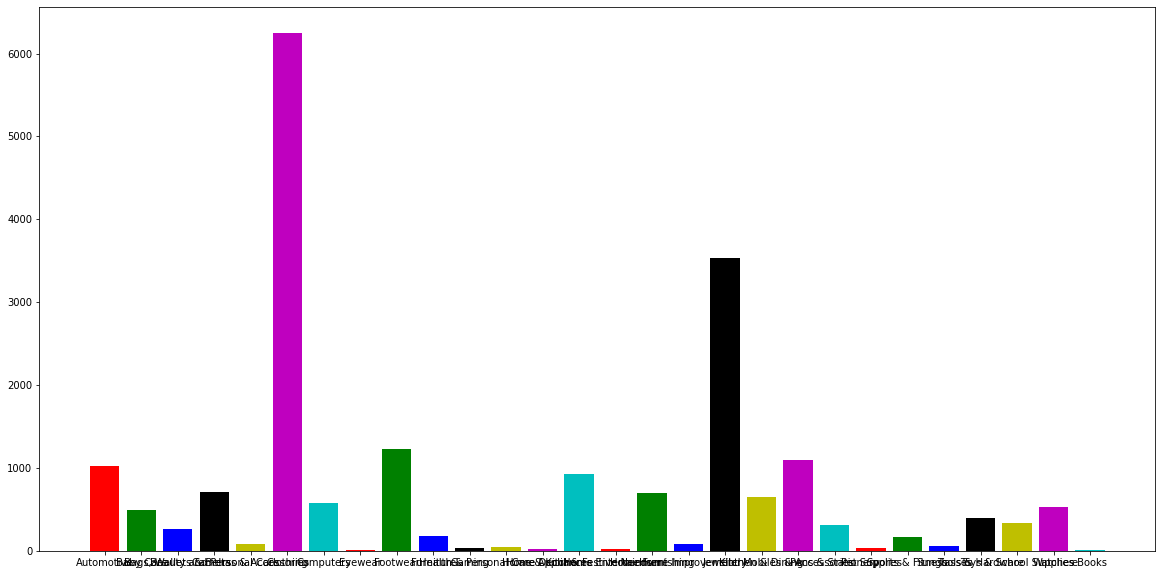

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.bar(freq_mapping.keys(), freq_mapping.values(), width=0.8, color='rgbkymc')
plt.show()

# ---------------------------------------------------------------------------------------------------------------------------------------------
This plot shows that some categories don't have enough samples and also don't qualify to be valid categories.

***Conclusion: After viewing this plot, it is not found much informative about invalid categories. So, let's get only top 28 categories and their frequency of occurence for more insightful information***

---------------------------------------------------------------------------------------------------------------------------------------------


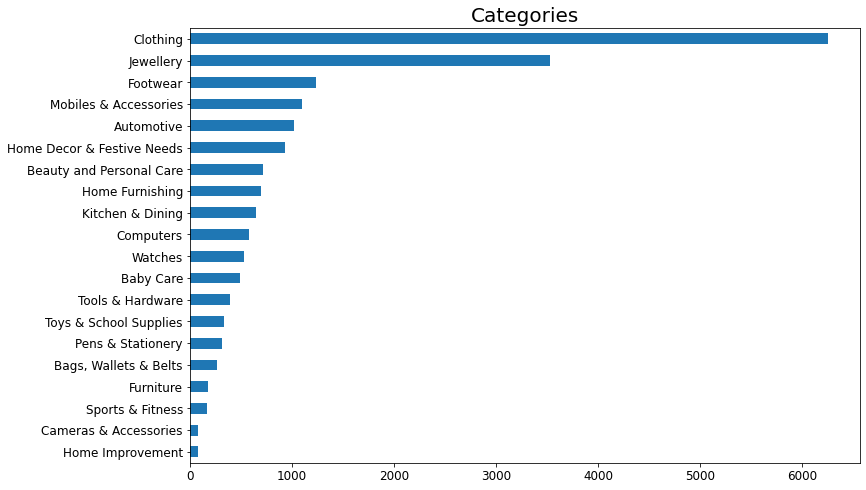

Categories with most products: 

Clothing                             6247
Jewellery                            3531
Footwear                             1231
Mobiles & Accessories                1099
Automotive                           1019
Home Decor & Festive Needs            929
Beauty and Personal Care              714
Home Furnishing                       700
Kitchen & Dining                      647
Computers                             578
Watches                               530
Baby Care                             491
Tools & Hardware                      391
Toys & School Supplies                330
Pens & Stationery                     313
Bags, Wallets & Belts                 265
Furniture                             180
Sports & Fitness                      166
Cameras & Accessories                  82
Home Improvement                       81
Sunglasses                             56
Health & Personal Care Appliances      43
Gaming                                 35
P

In [34]:
#####################################################################
# Plotting categories in descending order of their presence in dataset.
#####################################################################

plt.figure(figsize=(12,8))
df['primary_category'].value_counts()[:20].sort_values(ascending=True).plot(kind='barh')
plt.title('Categories',fontsize=20)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()
print('Categories with most products: \n')
print(df['primary_category'].value_counts()[:28])

**---------------------------------------------------------------------------------------------------------------------------------------------**

*This horizontal bar graph representation shows the dominance of "CLOTHING" category samples, followed by:*

1. Jewellery                            
2. Footwear                             
3. Mobiles & Accessories                
4. Automotive               

***This suggests that we should shuffle our data before splitting it for training and testing datasets, to avoid any bias while training.***





**---------------------------------------------------------------------------------------------------------------------------------------------**

In [40]:
###############################################################################################
# Viewing the labels with "-1" to verify that we have not left out any important category
###############################################################################################

r_df = df[['product_name', 'primary_category', 'description', 'label']].copy()
new_df = r_df[r_df['label']==-1]
print("Invalid categories: ",len(new_df))
new_df.head(n=15)


Invalid categories:  244


,product_name,primary_category,description,label
5,Eternal Gandhi Super Series Crystal Paper Weig...,Eternal,Key Features of Eternal Gandhi Super Series Cr...,-1
30,Bengal Blooms Rose Artificial Plant with Pot,Bengal,Key Features of Bengal Blooms Rose Artificial ...,-1
47,BuildTrack PIR Wireless Motion Sensor - One Sw...,BuildTrack,Key Features of BuildTrack PIR Wireless Motion...,-1
48,Skayvon SUMMERSIBLE SINGLE PHASE PUMP CONTROLL...,Skayvon,Key Features of Skayvon SUMMERSIBLE SINGLE PHA...,-1
52,Skayvon SUBMERSIBBLE THREE PHASE PUMP CONTROLL...,Skayvon,Key Features of Skayvon SUBMERSIBBLE THREE PHA...,-1
54,Behringer Xenyx 502 Analog Sound Mixer,Behringer,Specifications of Behringer Xenyx 502 Analog S...,-1
61,Noor Embroidered Women's Straight Kurta,Noor,Key Features of Noor Embroidered Women's Strai...,-1
64,Libas Printed Women's A-line Kurta,Libas,Specifications of Libas Printed Women's A-line...,-1
65,Libas Printed Women's Anarkali Kurta,Libas,Specifications of Libas Printed Women's Anarka...,-1
85,"Proence Weight Gainers, Mass Gainers",Food & Nutrition,"Specifications of Proence Weight Gainers, Mass...",-1


In [42]:
new_df = df[['description', 'label']]
new_df = new_df[new_df['label']>-1].copy()
print("Valid samples ready to be taken as input: ",new_df.shape)
print()
new_df.head(n=10)

Valid samples ready to be taken as input:  (19756, 2)



,description,label
0,Key Features of Alisha Solid Women's Cycling S...,5
1,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,9
2,Key Features of AW Bellies Sandals Wedges Heel...,8
3,Key Features of Alisha Solid Women's Cycling S...,5
4,Specifications of Sicons All Purpose Arnica Do...,21
6,Key Features of Alisha Solid Women's Cycling S...,5
7,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,9
8,"Key Features of dilli bazaaar Bellies, Corpora...",8
9,Key Features of Alisha Solid Women's Cycling S...,5
10,Key Features of Ladela Bellies Brand: LADELA C...,8




---

---




***Observation:*** 

Data looks in good shape and the text is ready to be pre-processed.





---

---





# Pre-processing Textual Data



---

---




We will perform few steps to get clean text:

1. Removing special characters
2. Removing Stopwords
3. Removing empty spaces
4. Lowercase conversion
5. Lemmatization (get words in raw form)
6. Stemming (to reduce vocab size and keep unique words only)
7. Tokenization (to get all words for vocab preparation)
8. Vectoization (to get vocabulary)


---

---





In [43]:
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)
        
        return preprocessed_text


final_corpus = [preprocess_text(sentence) for sentence in new_df['description'] if str(sentence).strip() !='']

final_corpus
# print(df['description'][0])
# print(final_corpus[0])


['feature alisha solid woman cycling short cotton lycra navy navy specification alisha solid woman cycling short short detail number content sale package pack fabric cotton lycra type cycling short general detail pattern solid ideal woman fabric care gentle machine wash lukewarm water bleach additional detail style code altht_3p_21 short',
 'fabhomedecor fabric double sofa finish color leatherette black mechanism type pull price fine deep seating experience save space click clack sofa easy fold vice versa simple click clack mechanism chrome mango wood frame long term durability double cushioned sofa provide extra softness make fine seating experience double easily sleep specification fabhomedecor fabric double sofa finish color leatherette black mechanism type pull installation demo installation demo detail installation demo product done free cost part purchase service partner visit location within business hour delivery product sofa general brand fabhomedecor mattress included deliver

In [48]:
#######################################

# Tokenize the final corpus

#######################################

tokenizer = nltk.WordPunctTokenizer()
word_tokenized_corpus = [tokenizer.tokenize(sent) for sent in final_corpus]
print("First tokenized sample in description:\n",word_tokenized_corpus[0])


First tokenized sample in description:
 ['feature', 'alisha', 'solid', 'woman', 'cycling', 'short', 'cotton', 'lycra', 'navy', 'navy', 'specification', 'alisha', 'solid', 'woman', 'cycling', 'short', 'short', 'detail', 'number', 'content', 'sale', 'package', 'pack', 'fabric', 'cotton', 'lycra', 'type', 'cycling', 'short', 'general', 'detail', 'pattern', 'solid', 'ideal', 'woman', 'fabric', 'care', 'gentle', 'machine', 'wash', 'lukewarm', 'water', 'bleach', 'additional', 'detail', 'style', 'code', 'altht_3p_21', 'short']


In [56]:
tokenizer = Tokenizer(num_words=50000, lower=True)
tokenizer.fit_on_texts(final_corpus)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(word_index)


Found 21330 unique tokens.
{'product': 1, 'woman': 2, 'flipkart': 3, 'online': 4, 'price': 5, 'free': 6, 'genuine': 7, 'delivery': 8, 'replacement': 9, 'cash': 10, 'shipping': 11, 'guarantee': 12, 'feature': 13, 'color': 14, 'shirt': 15, 'type': 16, 'detail': 17, 'specification': 18, 'material': 19, 'casual': 20, 'fabric': 21, 'collection': 22, 'general': 23, 'india': 24, 'cotton': 25, 'cover': 26, 'sleeve': 27, 'design': 28, 'pack': 29, 'solid': 30, 'number': 31, 'neck': 32, 'quality': 33, 'gold': 34, 'huge': 35, 'apparel': 36, 'necklace': 37, 'shop': 38, 'ideal': 39, 'package': 40, 'clothes': 41, 'branded': 42, 'brand': 43, 'printed': 44, 'sale': 45, 'size': 46, 'style': 47, 'black': 48, 'model': 49, 'best': 50, 'diamond': 51, 'look': 52, 'made': 53, 'alloy': 54, 'weight': 55, 'full': 56, 'white': 57, 'warranty': 58, 'inch': 59, 'round': 60, 'blue': 61, 'multicolor': 62, 'occasion': 63, 'yellow': 64, 'fashion': 65, 'pattern': 66, 'ring': 67, 'content': 68, 'girl': 69, 'wear': 70, 'li



---



---





Now that our data is ready, let's make a model for training and then predicting categories for the Test data.


---


---





# RNN-LSTM Model for Product Categorization

In [57]:
############################################################

# Preparing data(input) and target(output) tensors (X and Y)

############################################################

from keras.preprocessing import sequence

X = tokenizer.texts_to_sequences(final_corpus)


#  keeping the each decription's words length at max 300
#  padding with zeros if length is less than 300 
#  and clipping off words if length is more than 300

X = sequence.pad_sequences(X, maxlen=300)           
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(new_df["label"]).values
print("Shape of target tensor", Y.shape)

Shape of data tensor: (19756, 300)
Shape of target tensor (19756, 28)


In [60]:
#####################################################################

# Split the dataset into Training and Testing sets (after shuffling)

#####################################################################

from sklearn.model_selection import train_test_split

# We will keep 80% data for training and 20% data for testing

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
print()
print("Max length of each sentence: ",len(X_train[0]))

(15804, 300) (15804, 28)
(3952, 300) (3952, 28)

Max length of each sentence:  300


In [63]:
# FINAL MODEL
# import all RNN layers to be used

from keras.layers import Embedding, SimpleRNN, Dense, SpatialDropout1D, LSTM
from keras.models import Sequential
from tensorflow import keras

model = Sequential()
model.add(Embedding(22000,100,input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(28, activation='softmax'))
print("Model Summary and number of parameters: \n\n")
model.summary()

Model Summary and number of parameters: 


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          2200000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 300, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 28)                2828      
Total params: 2,283,228
Trainable params: 2,283,228
Non-trainable params: 0
_________________________________________________________________


In [64]:
# Compile Model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Train the Model

In [65]:
# Train Model
# We will also maintain validation data to prevent overfitting
# Training for 10 epochs 


hist = model.fit(X_train, Y_train, validation_split=0.2, epochs=10, batch_size=128)

Epoch 1/10
99/99 [==============================] - 143s 1s/step - loss: 2.5784 - accuracy: 0.3718 - val_loss: 1.3730 - val_accuracy: 0.6172
Epoch 2/10
99/99 [==============================] - 133s 1s/step - loss: 1.2403 - accuracy: 0.6457 - val_loss: 0.7559 - val_accuracy: 0.7877
Epoch 3/10
99/99 [==============================] - 134s 1s/step - loss: 0.6958 - accuracy: 0.8108 - val_loss: 0.4663 - val_accuracy: 0.8915
Epoch 4/10
99/99 [==============================] - 133s 1s/step - loss: 0.4119 - accuracy: 0.8941 - val_loss: 0.3246 - val_accuracy: 0.9146
Epoch 5/10
99/99 [==============================] - 134s 1s/step - loss: 0.2694 - accuracy: 0.9314 - val_loss: 0.2610 - val_accuracy: 0.9291
Epoch 6/10
99/99 [==============================] - 134s 1s/step - loss: 0.1904 - accuracy: 0.9506 - val_loss: 0.2494 - val_accuracy: 0.9389
Epoch 7/10
99/99 [==============================] - 135s 1s/step - loss: 0.1473 - accuracy: 0.9628 - val_loss: 0.2555 - val_accuracy: 0.9351
Epoch 8/10
99

In [66]:
# Checking Accuracy

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

124/124 [==============================] - 10s 80ms/step - loss: 0.2551 - accuracy: 0.9357
Test set
  Loss: 0.255
  Accuracy: 0.936




---

---
**Observation:**

Accuracy is **93.6%** which seems good.
We can improve this accuracy by training for more epochs and making sure that we don't overfit the model by training too much. 

So, we'll maintain two call backs (functionality provided by Keras):
1. ***Model Checkpoint*** -- to save the best model on the basis of provided metric (helps prevent overfitting)


2. ***EarlyStopping*** -- to stop training when a monitored quantity has stopped improving (helps in saving time)

---

---









In [67]:
# Save Model for future purposes in order to load weights without the need to train again next time.

hist1 = model.save("model1.h5")

# Plot Visualizations for Statistics Comparison

In [75]:
# Get values

loss = hist.history['loss']
val_loss = hist.history['val_loss']

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epochs = range(1, len(loss)+1)

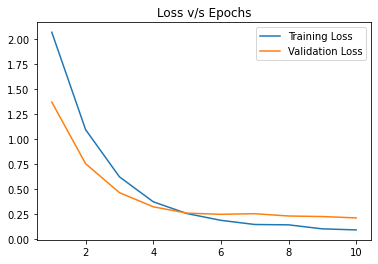

In [76]:
# Loss versus Epochs

plt.title('Loss v/s Epochs')
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.show()

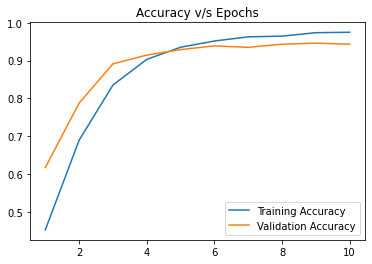

In [77]:
# Accuracy versus Epochs

plt.title('Accuracy v/s Epochs')
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend()
plt.show()

In [78]:
# Execute this cell to analyze initial model's performance

model.load_weights("model1.h5")

In [79]:
###########################################
# Callback 1
# Creating Model Checkpoint
###########################################


from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [81]:
############################################################
# Callback 2
# Earlystopping to stop training when metric stops improving
############################################################


from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_accuracy', patience=1)

In [82]:
# Train Model Again

hist = model.fit(X_train, Y_train, validation_split=0.2, epochs=10, batch_size=128, callbacks=[checkpoint, earlystop])

Epoch 1/10
99/99 [==============================] - 134s 1s/step - loss: 0.0676 - accuracy: 0.9818 - val_loss: 0.2103 - val_accuracy: 0.9488
Epoch 2/10
99/99 [==============================] - 136s 1s/step - loss: 0.0581 - accuracy: 0.9843 - val_loss: 0.1969 - val_accuracy: 0.9548
Epoch 3/10
99/99 [==============================] - 135s 1s/step - loss: 0.0532 - accuracy: 0.9864 - val_loss: 0.1847 - val_accuracy: 0.9567
Epoch 4/10
99/99 [==============================] - 134s 1s/step - loss: 0.0495 - accuracy: 0.9873 - val_loss: 0.1835 - val_accuracy: 0.9601
Epoch 5/10
99/99 [==============================] - 134s 1s/step - loss: 0.0408 - accuracy: 0.9896 - val_loss: 0.1813 - val_accuracy: 0.9576




---

---


**Observation:**

1. EarlyStopping callback stopped the training after Epoch 5 of 10 because our chosen metric **"Validation Accuracy"**  stopped improving and started dropping (which could have led to Overfitting and increased training accuracy, thereby performing bad on Test Data).

2. Model Checkpoint is saving the best statistics model with the best possible training and validation accuracy by primarily considering the minimum **"Validation Loss"** in a given Epoch.

***Next Step: ***
Measure Accuracy on Test Data and see some predictions.



---


---






# Measure Accuracy

In [83]:
# Load the best model saved while training

model.load_weights("best_model.h5")

In [84]:
# Accuracy on Test Data

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

124/124 [==============================] - 10s 79ms/step - loss: 0.2304 - accuracy: 0.9489
Test set
  Loss: 0.230
  Accuracy: 0.949




---


Accuracy on our **Test Data** is ***94.9%***

It has improved in comparison to the previous accuracy of 93.6%. This is a significant improvement and the model performs well enough to categorize for 28 labels.



---



In [85]:
# Accuray on Training Data

accr = model.evaluate(X_train,Y_train)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

494/494 [==============================] - 39s 78ms/step - loss: 0.0571 - accuracy: 0.9860
Train set
  Loss: 0.057
  Accuracy: 0.986




---
Accuracy on Training Data is ***98.6%***


---




# Let's view some Predictions

In [133]:
# Prediction 1:

new_description = ['Key Features of SMART TRADERS Girls Bellies Occasion: Party Material: Artificial Leather Color: Gold Heel Height: 0,Specifications of SMART TRADERS Girls Bellies General Occasion Party Ideal For Girls Sandal Details Type Bellies Heel Height 0 inch Outer Material Artificial Leather Color GOLDEN']

print(new_description)
sent = tokenizer.texts_to_sequences(new_description)
padded_sent = sequence.pad_sequences(sent, maxlen=300)
pred = model.predict(padded_sent)
labels = ['Automotive',
 'Baby Care',
 'Bags, Wallets & Belts',
 'Beauty and Personal Care',
 'Cameras & Accessories',
 'Clothing',
 'Computers',
 'Eyewear',
 'Footwear',
 'Furniture',
 'Gaming',
 'Health & Personal Care Appliances',
 'Home & Kitchen',
 'Home Decor & Festive Needs',
 'Home Entertainment',
 'Home Furnishing',
 'Home Improvement',
 'Jewellery',
 'Kitchen & Dining',
 'Mobiles & Accessories',
 'Pens & Stationery',
 'Pet Supplies',
 'Sports & Fitness',
 'Sunglasses',
 'Tools & Hardware',
 'Toys & School Supplies',
 'Watches',
 'eBooks']
print(pred, "\n", labels[np.argmax(pred)])

['Key Features of SMART TRADERS Girls Bellies Occasion: Party Material: Artificial Leather Color: Gold Heel Height: 0,Specifications of SMART TRADERS Girls Bellies General Occasion Party Ideal For Girls Sandal Details Type Bellies Heel Height 0 inch Outer Material Artificial Leather Color GOLDEN']
[[8.1187201e-05 4.3974080e-05 1.9636298e-04 1.2818281e-05 2.4882985e-07
  8.6976557e-05 2.1517902e-05 1.4623964e-07 9.9938095e-01 1.8008534e-05
  3.0962741e-07 1.0456873e-06 1.7670394e-07 8.4176376e-05 1.8770790e-07
  2.1620053e-05 2.7323335e-06 5.3014469e-06 3.3375147e-06 5.5356650e-06
  3.6650150e-08 1.2340323e-05 1.1098551e-06 1.1870153e-09 1.3565083e-06
  2.3502217e-08 1.7858358e-05 6.5215090e-07]] 
 Footwear


In [116]:
####################################################################################################
# Let's also consider the unidentified descriptions with -1 labels (Brand names were given as labels)
####################################################################################################

new_df = r_df[r_df['label']==-1]
print(len(new_df))
new_df.head()

244


,product_name,primary_category,description,label
5,Eternal Gandhi Super Series Crystal Paper Weig...,Eternal,Key Features of Eternal Gandhi Super Series Cr...,-1
30,Bengal Blooms Rose Artificial Plant with Pot,Bengal,Key Features of Bengal Blooms Rose Artificial ...,-1
47,BuildTrack PIR Wireless Motion Sensor - One Sw...,BuildTrack,Key Features of BuildTrack PIR Wireless Motion...,-1
48,Skayvon SUMMERSIBLE SINGLE PHASE PUMP CONTROLL...,Skayvon,Key Features of Skayvon SUMMERSIBLE SINGLE PHA...,-1
52,Skayvon SUBMERSIBBLE THREE PHASE PUMP CONTROLL...,Skayvon,Key Features of Skayvon SUBMERSIBBLE THREE PHA...,-1


We have 244 such samples. Let's predict their product categories.


---



In [149]:
# Predictions for ambiguously labeled samples (-1 cases)

for sent in new_df["description"]:
  sent = [preprocess_text(sent)]
  print(sent)
  sent = tokenizer.texts_to_sequences(sent)
  padded_sent = sequence.pad_sequences(sent, maxlen=300)
  pred = model.predict(padded_sent)
  
  print("Predicted Label: \n", labels[np.argmax(pred)])
  print()


['feature eternal gandhi super series crystal paper weight silver finish crystal paper weight product dimension beautiful product material crystal eternal gandhi super series crystal paper weight silver finish clear price office desk sparkle shine accent table elegant crystal paper weight multifaceted crystal feature gandhiji bust timeless message life message gandhi beautiful product gift near dear family business specification eternal gandhi super series crystal paper weight silver finish clear general model name gandhi paper weight mark dimension weight paper weight paper weight feature paper weight material crystal paper weight finish silver finish']
Predicted Label: 
 Home Decor & Festive Needs

['feature bengal bloom rose artificial plant assorted height bengal bloom rose artificial plant multicolor price bengal bloom decor home artificial flower attached wonderful specification bengal bloom rose artificial plant multicolor general brand bengal bloom model number bbajc218 type as

# Conclusion




---

---




After going through these descriptions and the predicted labels by our model, 
we can conclude that our model is performing quite accurately.

We can try to improve the model by experimenting with hyperparametrs and changing or adding few more layers to the LSTM model.

We might see a bit more accuracy but we must make sure that it doesn't overfit. Otherwise, our model will perform poorly on unseen and new dataset related to product categories.



---


---



